In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [2]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1e-6

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_pred_f = tf.clip_by_value(y_pred_f, 1e-7, 1.0 - 1e-7)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice


In [3]:
import tensorflow as tf

def bce_dice_loss(y_true, y_pred, lambda_dice=1.0):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)

    dice = dice_loss(y_true, y_pred)

    return bce + lambda_dice * dice


In [4]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (2. * intersection + smooth) / (union + smooth)


In [5]:
import tensorflow as tf

def iou_coef(y_true, y_pred, smooth=1.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)


In [6]:
import tensorflow as tf

model_path = "/content/drive/MyDrive/best_unet_model.keras"

model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        "dice_loss": dice_loss,
        "bce_dice_loss": bce_dice_loss,
        "dice_coef": dice_coef,
        "iou_coef": iou_coef
    }
)



In [7]:
BASE_PATH = '/content/drive/MyDrive/LEVIR-CD'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Val')
TEST_PATH = os.path.join(BASE_PATH, 'Test')


In [8]:
TRAIN_A_PATH = os.path.join(TRAIN_PATH, 'A')  # Pre-change images (Train)
TRAIN_B_PATH = os.path.join(TRAIN_PATH, 'B')  # Post-change images (Train)
TRAIN_LABEL_PATH = os.path.join(TRAIN_PATH, 'label')  # Binary change masks (Train)

VAL_A_PATH = os.path.join(VAL_PATH, 'A')  # Pre-change images (Val)
VAL_B_PATH = os.path.join(VAL_PATH, 'B')  # Post-change images (Val)
VAL_LABEL_PATH = os.path.join(VAL_PATH, 'label')  # Binary change masks (Val)

TEST_A_PATH = os.path.join(TEST_PATH, 'A')  # Pre-change images (Test)
TEST_B_PATH = os.path.join(TEST_PATH, 'B')  # Post-change images (Test)
TEST_LABEL_PATH = os.path.join(TEST_PATH, 'label')  # Binary change masks (Test)

In [9]:
def get_image_paths(directory):
    return sorted(glob(os.path.join(directory, '*.png')))

In [10]:
import os
from glob import glob

def get_image_paths(directory):
    return sorted(glob(os.path.join(directory, '*.png')))

train_a_images = get_image_paths(TRAIN_A_PATH)
train_b_images = get_image_paths(TRAIN_B_PATH)
train_label_images = get_image_paths(TRAIN_LABEL_PATH)

val_a_images = get_image_paths(VAL_A_PATH)
val_b_images = get_image_paths(VAL_B_PATH)
val_label_images = get_image_paths(VAL_LABEL_PATH)

test_a_images = get_image_paths(TEST_A_PATH)
test_b_images = get_image_paths(TEST_B_PATH)
test_label_images = get_image_paths(TEST_LABEL_PATH)

In [11]:
import tensorflow as tf

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 127.5 - 1.0
    return img

def load_and_preprocess_label(label_path):
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [256, 256])
    label = label / 255.0
    return label
def preprocess_data(a_path, b_path, label_path):
    img_a = tf.io.read_file(a_path)
    img_a = tf.image.decode_png(img_a, channels=3)
    img_a = tf.image.resize(img_a, [256, 256]) / 255.0

    img_b = tf.io.read_file(b_path)
    img_b = tf.image.decode_png(img_b, channels=3)
    img_b = tf.image.resize(img_b, [256, 256]) / 255.0

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [256, 256]) / 255.0

    img_combined = tf.concat([img_a, img_b], axis=-1)

    return img_combined, label





In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_a_images, train_b_images, train_label_images))
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


In [13]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_a_images, val_b_images, val_label_images))
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_a_images, test_b_images, test_label_images))
test_dataset = test_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


In [15]:
!cp -r "/content/drive/MyDrive/LEVIR-CD" /content/


In [16]:
import numpy as np
import tensorflow as tf

results = model.evaluate(test_dataset, verbose=0)

test_dice_coefficient = results[1]
test_binary_accuracy = results[3]

for img_combined, label in test_dataset.take(1):
    prediction = model(img_combined, training=False)

    loss_fn = tf.keras.losses.BinaryCrossentropy()
    manual_loss_value = loss_fn(label, prediction)
    manual_loss_value = manual_loss_value.numpy()

print("Test Dice Coefficient:", test_dice_coefficient)
print("Manual Loss:", manual_loss_value)
print("Test Binary Accuracy:", test_binary_accuracy)

Test Dice Coefficient: 0.7329376935958862
Manual Loss: 0.104745954
Test Binary Accuracy: 0.9726487398147583


In [17]:
test_sample = next(iter(test_dataset))
input_tensor, label_tensor = test_sample

predictions = model.predict(input_tensor)

print("Predictions Shape:", predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions Shape: (8, 256, 256, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


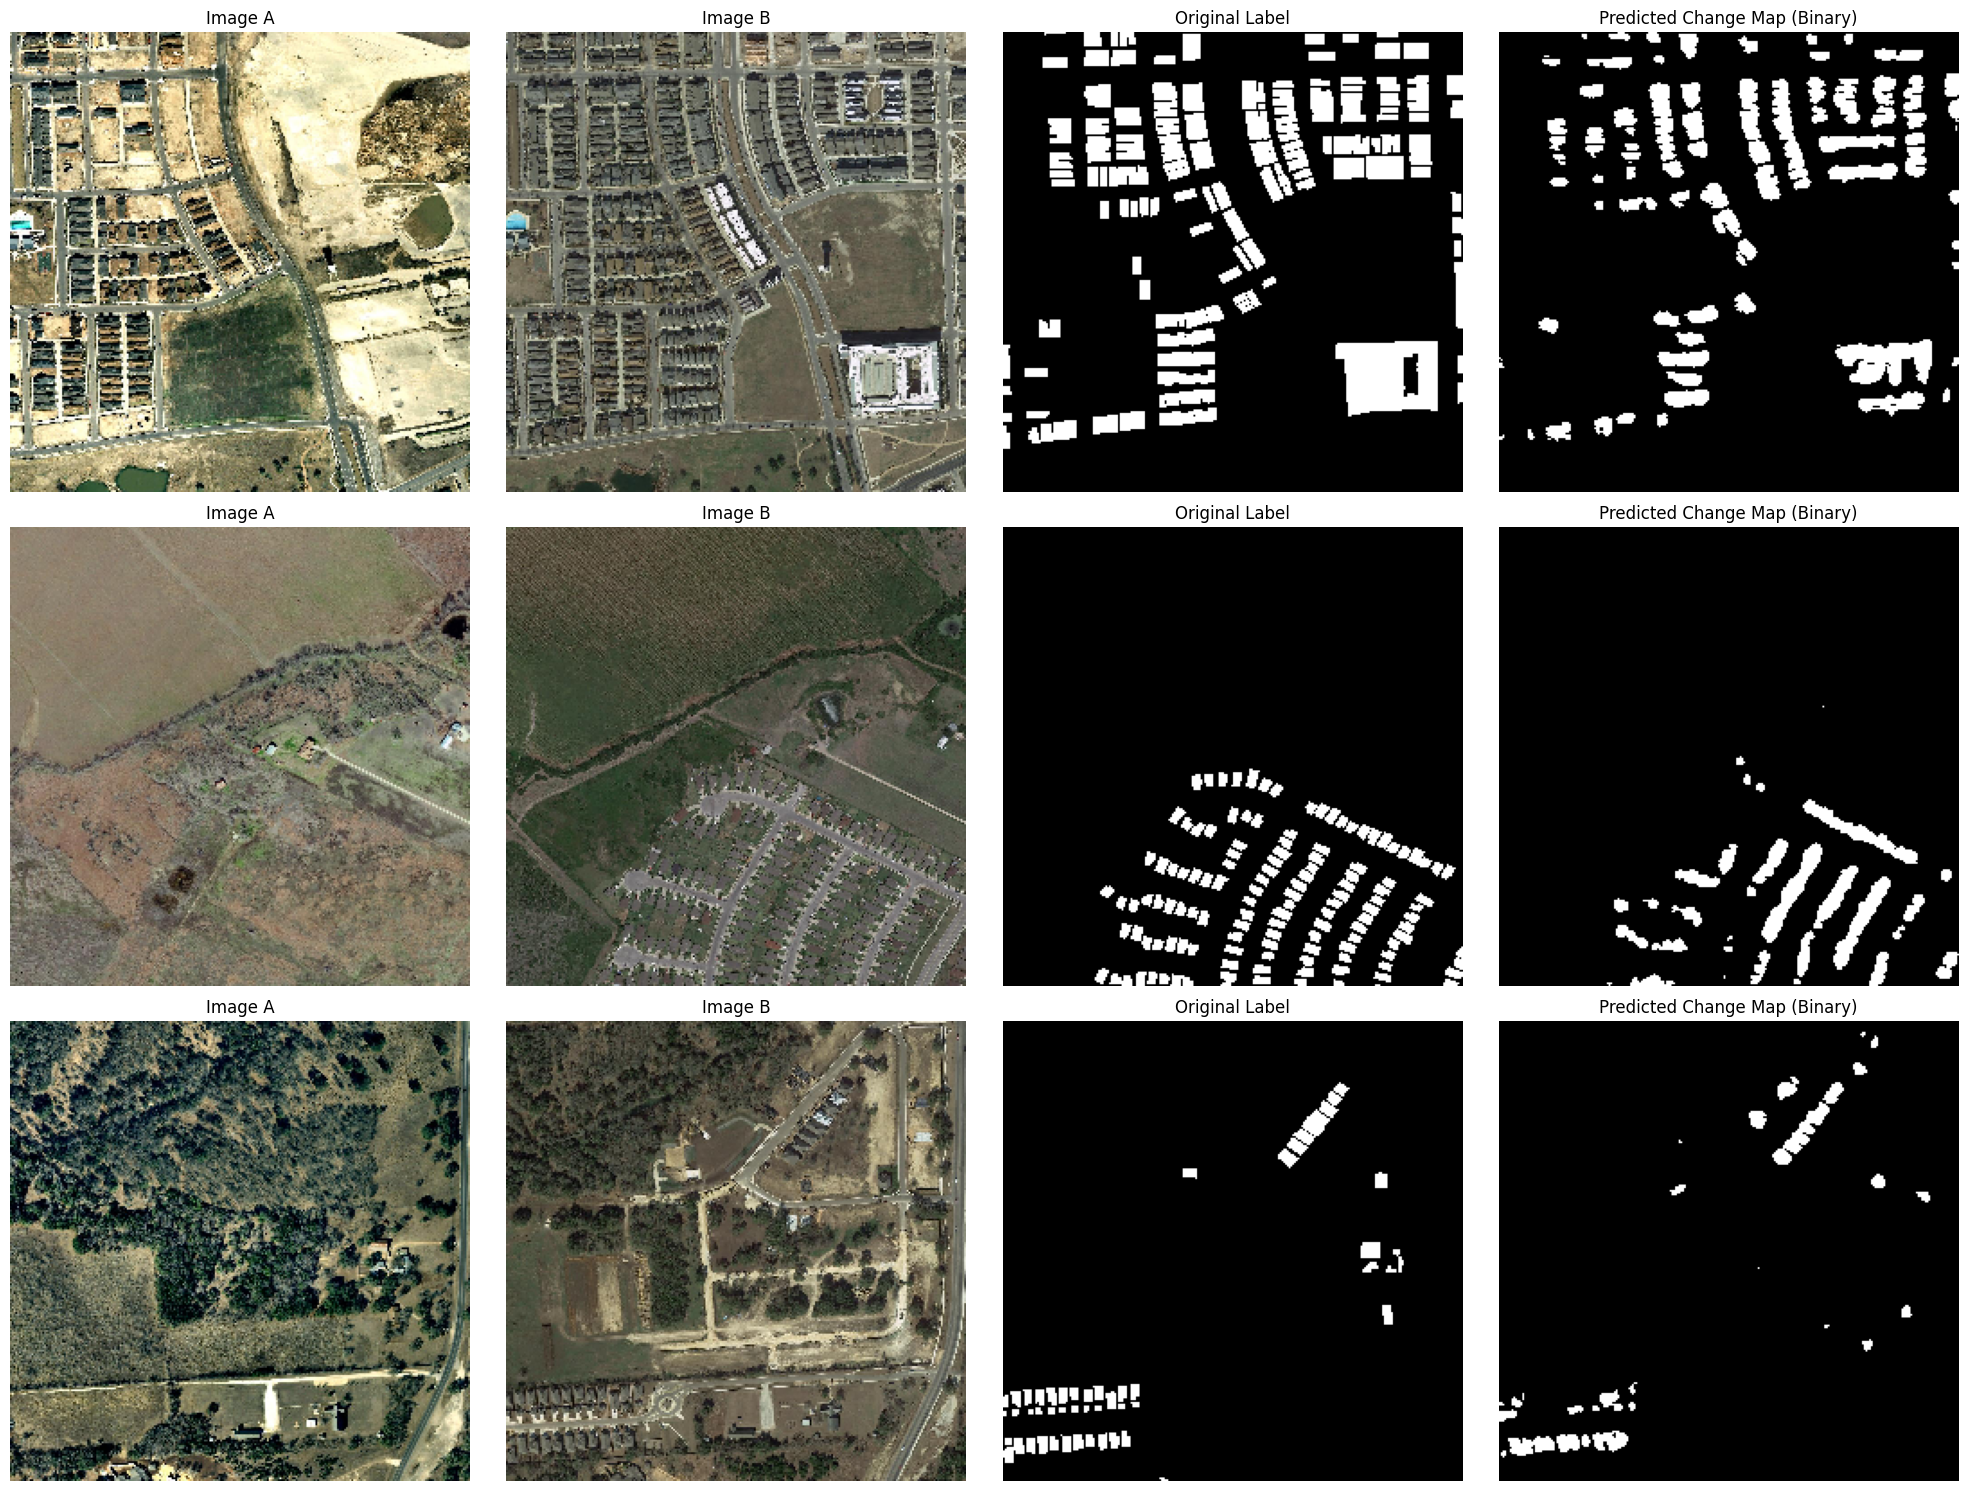

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_HEIGHT = 256
IMG_WIDTH = 256

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img) / 255.0
    return img.astype(np.float32)

def load_and_preprocess_label(label_path):
    label = load_img(label_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    label = img_to_array(label) / 255.0
    return label.astype(np.float32)

def visualize_random_predictions(model, a_paths, b_paths, label_paths, num_samples=3, threshold=0.5):
    num_samples = min(num_samples, len(a_paths))

    sample_indices = np.random.choice(len(a_paths), num_samples, replace=False)

    plt.figure(figsize=(20, 5 * num_samples))

    for i, idx in enumerate(sample_indices):
        img_a = load_and_preprocess_image(a_paths[idx])

        img_b = load_and_preprocess_image(b_paths[idx])

        img_combined = np.concatenate([img_a, img_b], axis=-1)
        img_combined = np.expand_dims(img_combined, axis=0)

        label = load_and_preprocess_label(label_paths[idx])

        prediction = model.predict(img_combined)[0]
        binary_prediction = (prediction > threshold).astype(np.float32)

        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(img_a)
        plt.title("Image A")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(img_b)
        plt.title("Image B")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(label.squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Original Label")
        plt.axis("off")

        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(binary_prediction.squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Predicted Change Map (Binary)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

a_paths = sorted(glob("/content/drive/MyDrive/LEVIR-CD/Test/A/*.png"))
b_paths = sorted(glob("/content/drive/MyDrive/LEVIR-CD/Test/B/*.png"))
label_paths = sorted(glob("/content/drive/MyDrive/LEVIR-CD/Test/label/*.png"))

visualize_random_predictions(model, a_paths, b_paths, label_paths, num_samples=3, threshold=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


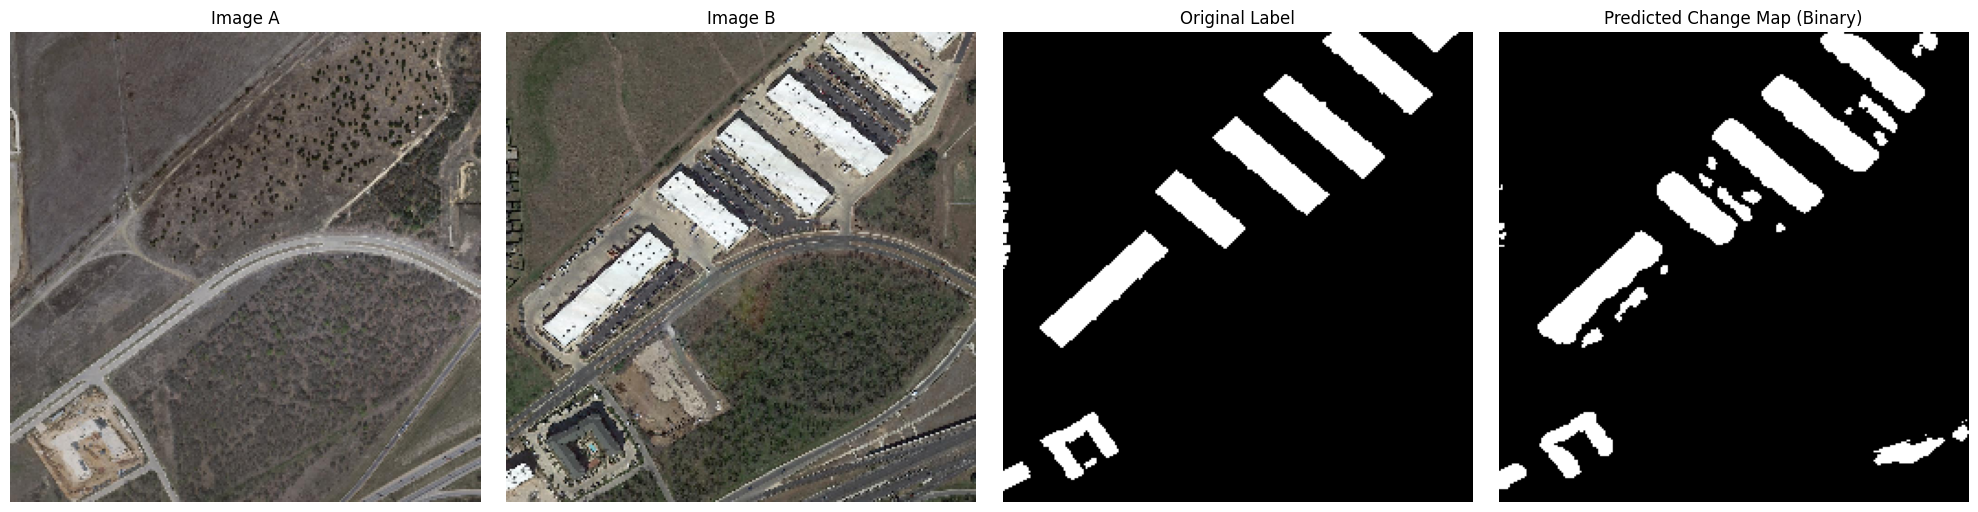

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_HEIGHT = 256  #
IMG_WIDTH = 256

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img) / 255.0
    return img.astype(np.float32)

def load_and_preprocess_label(label_path):
    label = load_img(label_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    label = img_to_array(label) / 255.0
    return label.astype(np.float32)

image_A_path = "/content/LEVIR-CD/Test/A/test_102.png"
image_B_path = "/content/LEVIR-CD/Test/B/test_102.png"
label_path = "/content/LEVIR-CD/Test/label/test_102.png"

img_a = load_and_preprocess_image(image_A_path)
img_b = load_and_preprocess_image(image_B_path)
label = load_and_preprocess_label(label_path)

input_image = np.concatenate([img_a, img_b], axis=-1)
input_image = np.expand_dims(input_image, axis=0).astype(np.float32)
prediction = model.predict(input_image)[0]

threshold = 0.5
binary_prediction = (prediction > threshold).astype(np.float32)

# Visualize results
plt.figure(figsize=(20, 5))

# Image A
plt.subplot(1, 4, 1)
plt.title("Image A")
plt.imshow(img_a)
plt.axis("off")

# Image B
plt.subplot(1, 4, 2)
plt.title("Image B")
plt.imshow(img_b)
plt.axis("off")

# Original Label (Ground Truth)
plt.subplot(1, 4, 3)
plt.title("Original Label")
plt.imshow(label.squeeze(), cmap="gray", vmin=0, vmax=1)
plt.axis("off")

# Predicted Change Map
plt.subplot(1, 4, 4)
plt.title("Predicted Change Map (Binary)")
plt.imshow(binary_prediction.squeeze(), cmap="gray", vmin=0, vmax=1)
plt.axis("off")

plt.tight_layout()
plt.show()